Tutorial 8: Fitting
===================

In this example, we'll fit the `Imaging` data we simulated in the previous exercise. we'll do this using model images
generated via a `Tracer`, and by comparing to the simulated image we'll get diagnostics about the quality of the fit.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


The `dataset_path` specifies where the data was output in the last tutorial, which is the directory 
`autolens_workspace/dataset/imaging/no_lens_light/howtolens/`.

In [2]:
dataset_path = path.join("dataset", "imaging", "no_lens_light", "howtolens")

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

The `imaging` is an `Imaging` object, which is a package of all components of the dataset, in particular:

 1) The image.
 2) The Point Spread Function (PSF).
 3) Its noise-map.
    
Which are all stored as `Array2D` objects.

In [3]:
print("Image:")
print(imaging.image)
print("Noise-Map:")
print(imaging.noise_map)
print("PSF:")
print(imaging.psf)

Image:
[0.01919715 0.0268063  0.02111711 ... 0.03665588 0.02910946 0.01159108]
Noise-Map:
[0.01993298 0.02055937 0.02009288 ... 0.0213429  0.02074524 0.01928653]
PSF:
[2.21033495e-12 1.98968011e-10 6.58891561e-09 8.02694246e-08
 3.59742603e-07 5.93115282e-07 3.59742603e-07 8.02694246e-08
 6.58891561e-09 1.98968011e-10 2.21033495e-12 1.98968011e-10
 1.79105296e-08 5.93115282e-07 7.22562334e-06 3.23829971e-05
 5.33905362e-05 3.23829971e-05 7.22562334e-06 5.93115282e-07
 1.79105296e-08 1.98968011e-10 6.58891561e-09 5.93115282e-07
 1.96412806e-05 2.39279782e-04 1.07237759e-03 1.76805174e-03
 1.07237759e-03 2.39279782e-04 1.96412806e-05 5.93115282e-07
 6.58891561e-09 8.02694246e-08 7.22562334e-06 2.39279782e-04
 2.91502450e-03 1.30642335e-02 2.15392796e-02 1.30642335e-02
 2.91502450e-03 2.39279782e-04 7.22562334e-06 8.02694246e-08
 3.59742603e-07 3.23829971e-05 1.07237759e-03 1.30642335e-02
 5.85498323e-02 9.65323539e-02 5.85498323e-02 1.30642335e-02
 1.07237759e-03 3.23829971e-05 3.5974260

To fit an image, we first specify a `Mask2D`, which describes the sections of the image that we fit.

Typically, we want to mask regions of the image where the lens and source galaxies are not visible, for example at 
the edges where the signal is entirely background sky and noise.

For the image we simulated, a 3" circular `Mask2D` will do the job.

A `Mask2D` also takes the `sub_size` parameter we are used to giving a grid. This does what it does for a `Grid2D` - 
defining the (masked) sub-grid used to calculate lensing quantities from a mask.

In [4]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=1,
    radius=3.0,
)

print(mask)  # 1 = True, which means the pixel is masked. Edge pixels are indeed masked.
print(mask[48:53, 48:53])  # Whereas central pixels are `False` and therefore unmasked.

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


We can use an `ImagingPlotter`.to compare the mask and the image - this is useful if we really want to `tailor` a 
mask to the lensed source's light (which in this example, we won't).

However, the mask is not an attribute of the `Imaging` object. Thus, we cannot use `Include2D(mask=True)` to plot it, 
as the `Imaging` doesn't know what the mask is!

To manually plot an object over the figure of another object, we can pass it to the `Visuals2D` object and then use
this in the `ImagingPlotter`. Note that the `Visuals2D` object can be used to customize the appearance of *any* figure
in PyAutoLens and is therefore a powerful means by which to create custom visuals!

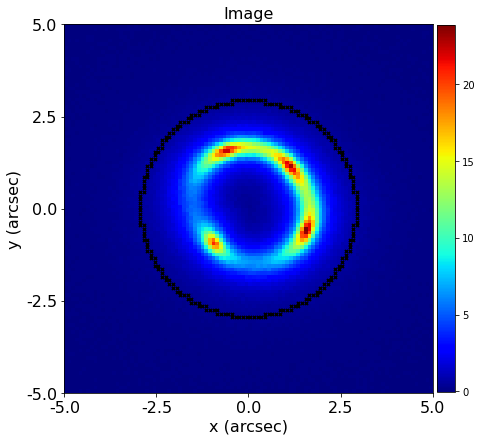

In [5]:
visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures(image=True)

To fit the data we create a `MaskedImaging` object, which is a `package` of all parts of a data-set we need in order 
to fit it with a lens model:

 1) The imaging-data, including the image, PSF (so that when we compare a tracer`s image to the image instrument we 
 can include blurring due to the telescope optics) and noise-map (so our goodness-of-fit measure accounts for 
 noise in the observations).

 2) The mask, so that only the regions of the image with a signal are fitted.

 3) A `Grid2D` aligned to the `Imaging` data's pixels, so the tracer`s image is generated on the same (masked) `Grid2D` 
 as the image.

In [6]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

Note that because the `Mask2D` is now an attribute of the `MaskedImaging` we can plot it using `Include2D`.

Because it is an attribute, the `mask` now also automatically `zooms` our plot around the masked region only. This 
means that if our image is very large, we focus-in on the lens and source galaxies.

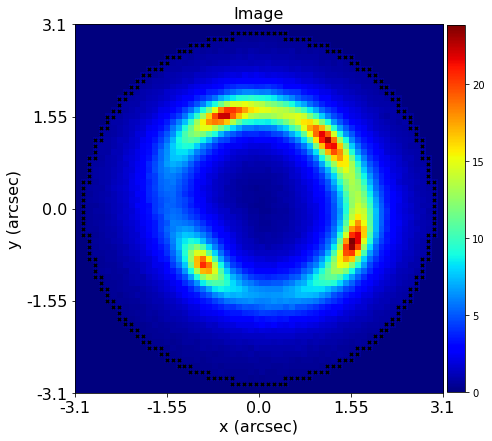

In [7]:
include_2d = aplt.Include2D(mask=True)

imaging_plotter = aplt.ImagingPlotter(imaging=masked_imaging, include_2d=include_2d)
imaging_plotter.figures(image=True)

By printing its attributes, we can see that it does indeed contain the mask, masked image, masked noise-map, psf and so 
on.

In [8]:
print("Mask2D")
print(masked_imaging.mask)
print()
print("Masked Image:")
print(masked_imaging.image)
print()
print("Masked Noise-Map:")
print(masked_imaging.noise_map)
print()
print("PSF:")
print(masked_imaging.psf)
print()

Mask2D
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Masked Image:
[0.47245674 0.49103703 0.47856372 ... 0.31061426 0.40172222 0.39672031]

Masked Noise-Map:
[0.04368282 0.04438607 0.04391521 ... 0.03699614 0.04089508 0.04069072]

PSF:
[2.21033495e-12 1.98968011e-10 6.58891561e-09 8.02694246e-08
 3.59742603e-07 5.93115282e-07 3.59742603e-07 8.02694246e-08
 6.58891561e-09 1.98968011e-10 2.21033495e-12 1.98968011e-10
 1.79105296e-08 5.93115282e-07 7.22562334e-06 3.23829971e-05
 5.33905362e-05 3.23829971e-05 7.22562334e-06 5.93115282e-07
 1.79105296e-08 1.98968011e-10 6.58891561e-09 5.93115282e-07
 1.96412806e-05 2.39279782e-04 1.07237759e-03 1.76805174e-03
 1.07237759e-03 2.39279782e-04 1.96412806e-05 5.93115282e-07
 6.58891561e-09 8.02694246e-08 7.22562334e-06 2.39279782e

The masked image and noise-map are again stored in 2D and 1D. 

However, the 1D array now corresponds only to the pixels that were not masked, whereas for the 2D array, all edge 
values are masked and are therefore zeros.

In [9]:
print("The 2D Masked Image and 1D Image of unmasked entries")
print(masked_imaging.image.shape_native)
print(masked_imaging.image.shape_slim)
print(masked_imaging.image.native)
print(masked_imaging.image.slim)
print()
print("The 2D Masked Noise-Map and 1D Noise-Map of unmasked entries")
print(masked_imaging.noise_map.shape_native)
print(masked_imaging.noise_map.shape_slim)
print(masked_imaging.noise_map.native)
print(masked_imaging.noise_map.slim)

The 2D Masked Image and 1D Image of unmasked entries
(100, 100)
2828
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.47245674 0.49103703 0.47856372 ... 0.31061426 0.40172222 0.39672031]

The 2D Masked Noise-Map and 1D Noise-Map of unmasked entries
(100, 100)
2828
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.04368282 0.04438607 0.04391521 ... 0.03699614 0.04089508 0.04069072]


The masked data also has a `Grid2D`, where only coordinates which are not masked are included (the masked 2D values are 
set to [0.0. 0.0]).

In [10]:
print("Masked Grid2D")
print(masked_imaging.grid.native)
print(masked_imaging.grid.slim)

Masked Grid2D
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 ...

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]]
[[ 2.975 -0.475]
 [ 2.975 -0.425]
 [ 2.925 -0.475]
 ...
 [-2.925  0.475]
 [-2.975  0.425]
 [-2.975  0.475]]


To fit an image, create an image using a `Tracer`. Lets use the same `Tracer` we simulated the `Imaging` instrument 
with (thus, our fit is `perfect`).

Its worth noting that below, we use the `MaskedImaging`'s `Grid2D` to setup the `Tracer`. This ensures that our 
image-plane image is the same resolution and alignment as our lens data's masked image.

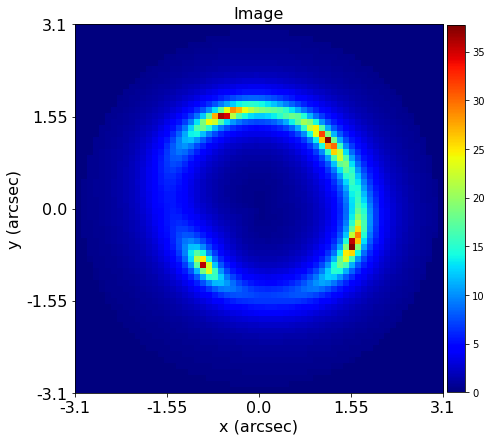

In [11]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)


tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=masked_imaging.grid)
tracer_plotter.figures(image=True)

To fit the image, we pass the `MaskedImaging` and `Tracer` to a `FitImaging` object. This performs the following:

 1) Blurs the tracer`s image with the lens data's PSF, ensuring the telescope optics are included in the fit. This 
 creates the fit`s `model_image`.

 2) Computes the difference between this model_image and the observed image-data, creating the fit`s `residual_map`.

 3) Divides the residual-map by the noise-map, creating the fit`s `normalized_residual_map`.

 4) Squares every value in the normalized residual-map, creating the fit`s `chi_squared_map`.

 5) Sums up these chi-squared values and converts them to a `log_likelihood`, which quantifies how good the tracer`s 
 fit to the data was (higher log_likelihood = better fit).

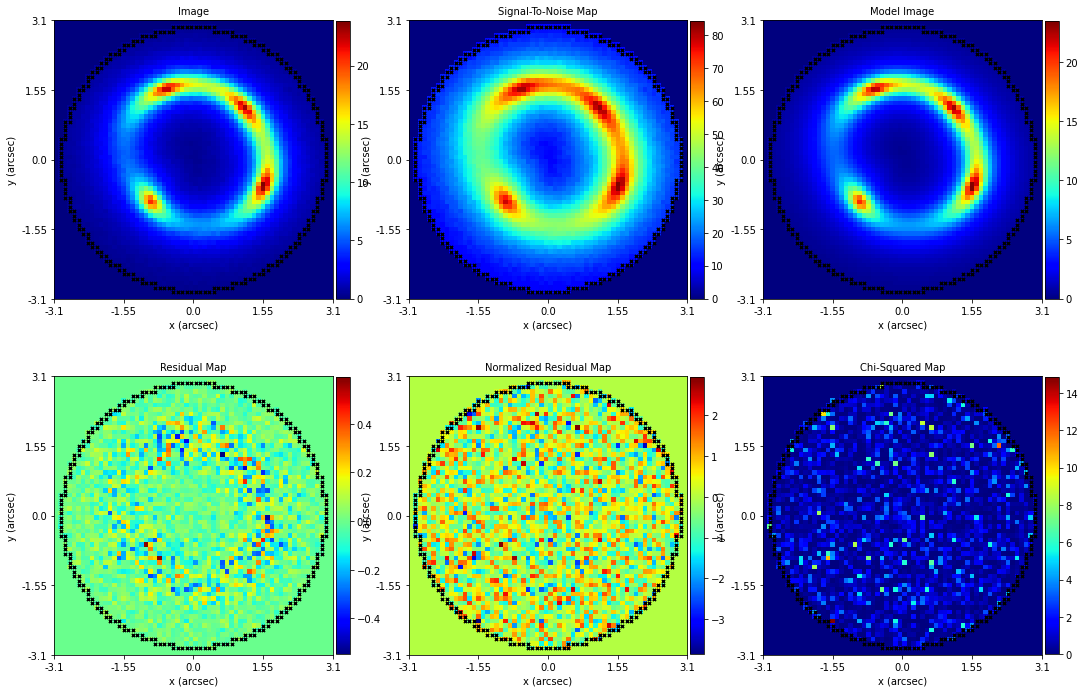

In [12]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

We can print the fit`s attributes. As usual, we can choose whether to return the fits in 2d or 1d, and in 2d if we 
don't specify where we'll get all zeros, as the edges were masked:

In [13]:
print("Model-Image:")
print(fit.model_image.native)
print(fit.model_image.slim)
print()
print("Residual Maps:")
print(fit.residual_map.native)
print(fit.residual_map.slim)
print()
print("Chi-Squareds Maps:")
print(fit.chi_squared_map.native)
print(fit.chi_squared_map.slim)

Model-Image:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.47274716 0.48040866 0.48584599 ... 0.34857889 0.347461   0.34493609]

Residual Maps:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[-0.00029043  0.01062837 -0.00728227 ... -0.03796464  0.05426122
  0.05178422]

Chi-Squareds Maps:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[4.42036176e-05 5.73376569e-02 2.74981542e-02 ... 1.05304201e+00
 1.76050374e+00 1.61958691e+00]


Of course, the central unmasked pixels have non-zero values.

In [14]:
model_image = fit.model_image.native
print(model_image[48:53, 48:53])
print()

residual_map = fit.residual_map.native
print("Residuals Central Pixels:")
print(residual_map[48:53, 48:53])
print()

print("Chi-Squareds Central Pixels:")
chi_squared_map = fit.chi_squared_map.native
print(chi_squared_map[48:53, 48:53])

[[0.51073107 0.43923705 0.44426157 0.52294973 0.63790034]
 [0.59313273 0.48906411 0.46409377 0.52666356 0.63038627]
 [0.70403497 0.56198169 0.49494146 0.5278853  0.61668405]
 [0.77654397 0.60969603 0.52355147 0.53722059 0.61339537]
 [0.82193945 0.65471447 0.57305729 0.57841536 0.64268645]]

Residuals Central Pixels:
[[ 0.05739774  0.04590372  0.02092824 -0.00038361 -0.04543299]
 [-0.03686727 -0.06760255 -0.0725729   0.01333023  0.04705293]
 [-0.05929836  0.06531503 -0.06839187 -0.07878137 -0.01331595]
 [-0.04012269  0.05302936 -0.03978186  0.06722059  0.06339537]
 [ 0.00527278  0.03471447 -0.04694271 -0.04825131  0.06935311]]

Chi-Squareds Central Pixels:
[[1.47928084e+00 1.08033038e+00 2.32483613e-01 7.09097620e-05
  8.94261711e-01]
 [6.21331851e-01 2.62920933e+00 3.21460938e+00 8.32952955e-02
  8.54335010e-01]
 [1.41645873e+00 1.75968868e+00 2.66496181e+00 3.39089016e+00
  7.56281022e-02]
 [5.77399397e-01 1.10607826e+00 8.13298370e-01 1.92433695e+00
  1.55214490e+00]
 [8.99542819e-03

The fit also gives a log likelihood, which is a single-figure estimate of how good the model image fitted the simulated 
image (in unmasked pixels only!).

In [15]:
print("Likelihood:")
print(fit.log_likelihood)

Likelihood:
3059.0130777053137


We can customize the `MaskedImaging` we set up, using the `SettingsMaskedImaging` object. 

For example, we can: 

 - Specify the `Grid2D` used by the `MaskedImaging` to fit the data, where we below increase it from its default 
 value of 2 to 4.

In [16]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=4)

masked_imaging_custom = al.MaskedImaging(
    imaging=imaging, mask=mask, settings=settings_masked_imaging
)

The use of `Settings` objects is a core feature of the **PyAutoLens** API and will appear throughout the **HowToLens**
chapters for setting up many different aspects of a **PyAutoLens** fit, so take note!

We used the same `Tracer` to create and fit the image, giving an excellent fit. The residual-map and chi-squared-map, 
show no signs of the source-`Galaxy`'s light present, indicating a good fit. This solution will translate to one of the 
highest-log_likelihood solutions possible.

Lets change the `Tracer`, so that it`s near the correct solution, but slightly off. Below, we slightly offset the lens 
galaxy, by 0.005"

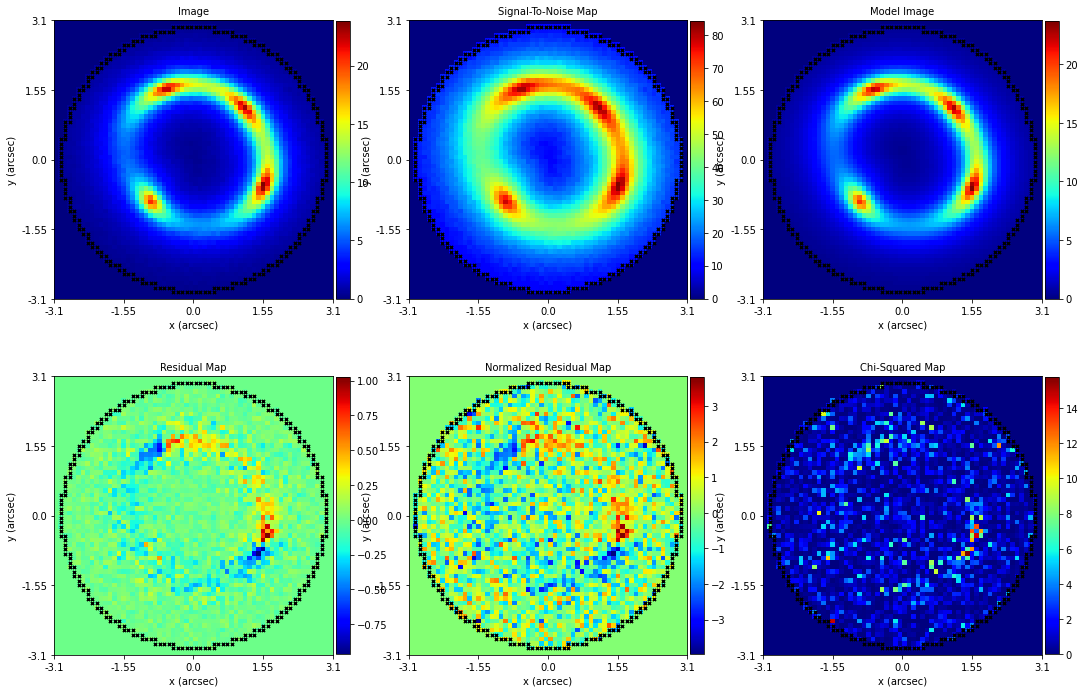

In [17]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.005, 0.005), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)


tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

Residuals now appear at the locations of the source galaxy, increasing the chi-squared values (which determine 
our log_likelihood).

Lets compare the log likelihood to the value we computed above (which was 4372.90):

In [18]:
print("Previous Likelihood:")
print(2967.0488)
print("New Likelihood:")
print(fit.log_likelihood)

Previous Likelihood:
2967.0488
New Likelihood:
2759.273140465849


It decreases! As expected, this model is a worse fit to the data.

Lets change the `Tracer`, one more time, to a solution nowhere near the correct one.

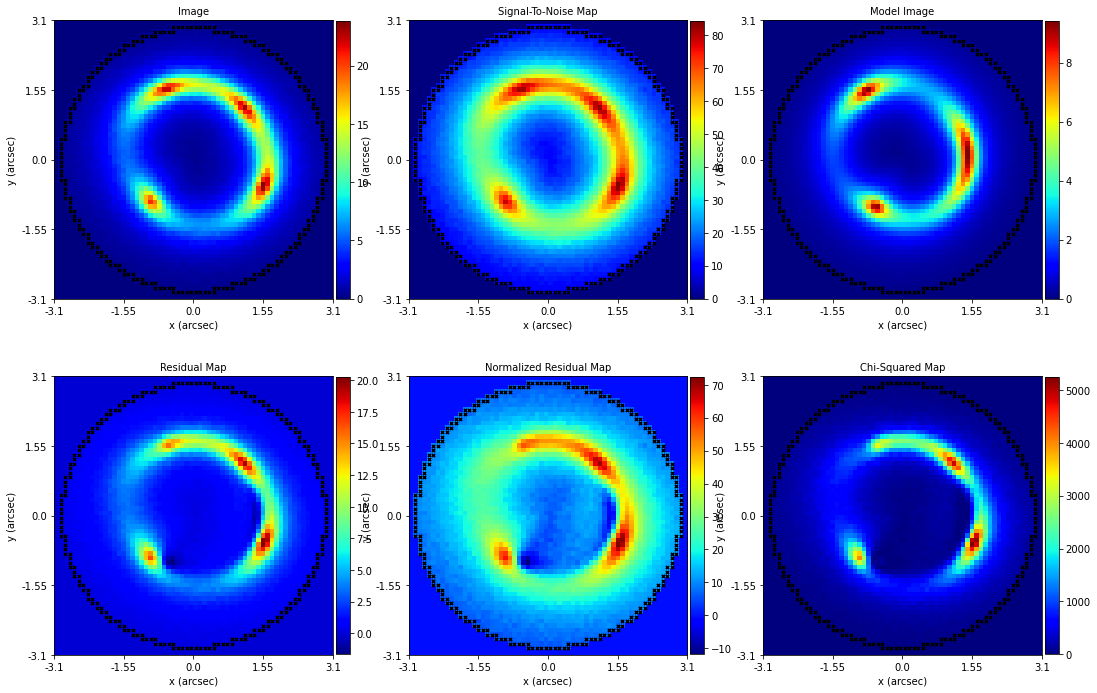

In [19]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.005, 0.005),
        einstein_radius=1.5,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.7, phi=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.2, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.5,
        effective_radius=0.8,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

Clearly, the model provides a terrible fit and this `Tracer` is not a plausible representation of the `Imaging` dataset
(of course, we already knew that, given that we simulated it!)

The log likelihood drops dramatically, as expected.

In [20]:
print("Previous Likelihoods:")
print(2967.0488)
print(2687.4724)
print("New Likelihood:")
print(fit.log_likelihood)

Previous Likelihoods:
2967.0488
2687.4724
New Likelihood:
-654474.5910926136


Congratulations, you`ve fitted your first strong lens with **PyAutoLens**! Perform the following exercises:

 1) In this example, we `knew` the correct solution, because we simulated the lens ourselves. In the real Universe, 
 we have no idea what the correct solution is. How would you go about finding the correct solution? Could you find a 
 solution that fits the data reasonable through trial and error?